# Libraries

In [1]:
import tqdm
import spacy
import numpy as np
import regex as re
import pandas as pd
import seaborn as sns

import plotly.graph_objects as go
import plotly.offline as pyo

import matplotlib.pyplot as plt

import pyLDAvis
import pyLDAvis.gensim_models as gensim_models
import pyLDAvis.gensim_models as gensimvis

import gensim
# from gensim.models import wrappers
# from gensim.models.wrappers import LdaMallet
import gensim.corpora as corpora
from gensim.corpora import dictionary
from gensim.utils import simple_preprocess
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel

import nltk
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 


# Think these can be removed
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD

/Users/austinboring/opt/anaconda3/envs/broke-the-other/lib/python3.10/site-packages/gensim/matutils.py:22: DeprecationWarning:

Please use `triu` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.



# Importing -- Fixing columns

In [2]:
full = pd.read_csv('../Data/Data-Cleaned/238k-Uncleaned')

In [3]:
# Renaming tweets column, dropping unnamed column, making tweets strings

full['tweets'] = full['0']
full.reset_index(inplace = True)
full = full.drop(columns = ['0', 'Unnamed: 0', 'index'])
# eh
full.drop_duplicates(inplace = True, ignore_index = True)

# Preprocessing ---- 

In [4]:
# Function for Gensim simple preprocessor --- 
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        
# STOPWORDS ==========================================
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words]for doc in texts]
# Stop Words list -- Can be Edited
stop_words = stopwords.words('english')
# stop_words.extend(['tesla', 'c,', 'x', 't', 'p', 'amp', 'car', 'get', 'go', 'use'])
stop_words.extend(['tesla', 'c,', 'x', 't', 'p', 'amp', 'car',
                   'get', 'go', 'use', 'elon', 'musk', 'elon_musk', 'electric', 'vehicle', 'rt'])
wnl = WordNetLemmatizer()

# BIGRAMS===============================================
def make_bigrams(texts):
    return bigram_mod[texts]

# TRIGRAMS =============================================
def make_trigrams(texts):
    return trigram_mod[bigram_mod[texts]]

# LEMMATIZING ==========================================
def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:         
        return None    
def lemmatize_texts(tweet):
     for i in tweet:
        word = (map(lambda x: (x[0], pos_tagger(x[1])), pos_tag(tweet))) 
        word_lem = " ".join([wnl.lemmatize(x[0], x[1]) for x in word if x[1] is not None])
        return word_lem

In [5]:
# remove punctuation and lowercase all
full['preprep'] = full['tweets'].map(lambda x: re.sub('[,\.!?]', '', x.lower()))
#  Removing @ handles, links-- strip whitespace breaks and tabs
full['preprep'] = full['preprep'].map(lambda x: re.sub(r"@\w+|http\S+", "", x).strip()\
                                      .replace("\r", "").replace("\n", "").replace("\t", ""))

In [6]:
# Creates a list of all tweets in full.preprep
data = full.preprep.values.tolist()

# Uses gensims simple preprocessor on all tweets in list
# Ouputs list of lists of tokenized tweets
data_words = list(sent_to_words(data))

In [7]:
# Bigram ---
# higher hyperparameter values =  fewer phrases.
bigram = gensim.models.Phrases(data_words, min_count=2, threshold=20) # orig -- 3/ 75
bigram_mod = gensim.models.phrases.Phraser(bigram)

# TriGrams --
trigram = gensim.models.Phrases(bigram[data_words], threshold=60)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [8]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
# lemmatize
data_lemmatized = [lemmatize_texts(tweet) for tweet in data_words_bigrams]

In [9]:
print(len(data_words), len(data_lemmatized))

126510 126510


In [10]:
# Getting indices of all nones
indices_of_nones = [(i) for i,x  in enumerate(data_lemmatized) if x == None]
len(indices_of_nones)

386

In [11]:
# Dropping None values using indices aquired above
lem_drop_None = [(i, x) for (i, x) in enumerate(data_lemmatized) if i not in indices_of_nones]
len(lem_drop_None)

126124

In [12]:
# Getting indices of all short tweets
indices_short_tweets = [i for (i,x) in lem_drop_None if (len(x.split(' ')) <= 5)]
len(indices_short_tweets)

38763

In [13]:
lem_noShort_noNone = [(i, x) for (i, x) in lem_drop_None if i not in indices_short_tweets]
len(lem_noShort_noNone)

87361

In [14]:
lem_noNone = [x.split() for (i, x) in lem_noShort_noNone]

In [15]:
id2word = corpora.Dictionary(lem_noNone)
print(len(id2word)) 

62470


In [16]:
# This can be Tuned --- and probably should be
id2word.filter_extremes(no_below=6, no_above=.95)
print(len(id2word))

13580


In [17]:
corpus = [id2word.doc2bow(d) for d in lem_noNone]

## The Rosetta Stone

In [18]:
print(       (lem_noNone[8654]), 
      '\n\n',(lem_noShort_noNone[8654]), 
      '\n\n',(full.preprep.iloc[13394]), 
      '\n\n',(full.tweets.iloc[13394]))

['take', 'forest', 'rather', 'fly', 'hate', 'fucking', 'shuttle', 'bud', 'schedule', 'time'] 

 (13394, 'take forest rather fly hate fucking shuttle bud schedule time') 

 so i can take the tesla to electric forest i’d rather fly but i hate fucking with shuttles and bud schedule times 

 So I can take the Tesla to Electric Forest. I’d rather fly but I hate fucking with shuttles and bud schedule times https://t.co/QRWyFylQmw


# Modeling

In [19]:
# Instantiating a Base LDA model
base_model = LdaMulticore(corpus=corpus,
                          num_topics=5,
                          id2word=id2word,
                          workers=7,
                          passes=5,
                          chunksize=2000,
                          random_state = 42)
words = [re.findall(r'"([^"]*)"',t[1]) for t in base_model.print_topics()]
topics = [' '.join(t[0:10]) for t in words]

for id, t in enumerate(topics): 
    print(f"------ Topic {id + 1} ------")
    print(t, end="\n\n")

------ Topic 1 ------
car make company world good esg say thing people fire

------ Topic 2 ------
car know find door drive people free open model driver

------ Topic 3 ------
people ev make say company want think work drive car

------ Topic 4 ------
stock buy twitter market sell go price think share make

------ Topic 5 ------
car charge spot buy need battery motor world ev state



In [20]:
# a measure of how good the model is. lower the better
base_perplexity = base_model.log_perplexity(corpus)

# Compute Coherence Score
coherence_model = CoherenceModel(model=base_model, texts=lem_noNone, 
                                   dictionary=id2word, coherence='c_v')

coherence_lda_model_base = coherence_model.get_coherence()
print('\nCoherence Score: ', coherence_lda_model_base, '\n\nPerplexity: ', base_perplexity)


Coherence Score:  0.2752541810515012 

Perplexity:  -7.904977907983739


In [42]:
newer_model = LdaMulticore(corpus=corpus,
                          num_topics=5,
                          id2word=id2word,
                          workers=4,
                          passes=20,
                          alpha = 0.909 , 
                          eta = 0.01,
                          chunksize=1500,
                          random_state = 42)
newer_words = [re.findall(r'"([^"]*)"',t[1]) for t in newer_model.print_topics()]
newer_topics = [' '.join(t[0:20]) for t in newer_words]

for id, t in enumerate(newer_topics): 
    print(f"------ Topic {id + 1} ------")
    print(t, end="\n\n")

------ Topic 1 ------
make company good world find big free thing help people

------ Topic 2 ------
know people see drive think even really fire get open

------ Topic 3 ------
say work want start spacex also day look ford leave

------ Topic 4 ------
stock buy twitter go sell market price back tsla money

------ Topic 5 ------
car ev need new battery year charge vehicle spot first



In [43]:
# a measure of how good the model is. lower the better
new_perplexity = newer_model.log_perplexity(corpus)

# Compute Coherence Score
coherence_model = CoherenceModel(model=newer_model, texts=lem_noNone, 
                                   dictionary=id2word, coherence='c_v')

coherence_lda_model_new = coherence_model.get_coherence()
print('\nCoherence Score: ', coherence_lda_model_new, '\n\nPerplexity: ', new_perplexity)


Coherence Score:  0.33764029361934444 

Perplexity:  -11.316539469020194


In [44]:
pyLDAvis.enable_notebook()
gensimvis.prepare(newer_model, corpus, id2word)

/Users/austinboring/opt/anaconda3/envs/broke-the-other/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/Users/austinboring/opt/anaconda3/envs/broke-the-other/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/Users/austinboring/opt/anaconda3/envs/broke-the-other/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/Users/austinboring/opt/anaconda3/envs/broke-the-other/lib/python3.10/site-packages/past/builtins/misc.py:

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.074992 -0.013583       1        1  21.258891
3      0.005595  0.173295       2        1  20.916416
0     -0.209796 -0.274018       3        1  20.012554
4      0.359973 -0.113992       4        1  19.356433
2     -0.080780  0.228297       5        1  18.455706, topic_info=        Term          Freq         Total Category  logprob  loglift
88       car  13637.000000  13637.000000  Default  30.0000  30.0000
116    stock  12958.000000  12958.000000  Default  29.0000  29.0000
109      buy  11415.000000  11415.000000  Default  28.0000  28.0000
153     make   9597.000000   9597.000000  Default  27.0000  27.0000
233  company   7149.000000   7149.000000  Default  26.0000  26.0000
..       ...           ...           ...      ...      ...      ...
140     look   1457.685372   3307.063801   Topic5  -4.8990   0.8706
320     give   1172.701771   2370.132427   Topic5  -5.1166   0.9862
128   people   1114.355493   6954.144036   Topic5  -5.1676  -0.1413
41      well    974.712821   3918.557668   Topic5  -5.3015   0.2985
324     take    958.258971   4124.842208   Topic5  -5.3185   0.2301

[322 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1472      1  0.999112  accident
11        5  0.999872    accord
230       1  0.090887      also
230       2  0.118603      also
230       3  0.099626      also
...     ...       ...       ...
290       1  0.001672      year
290       2  0.200179      year
290       3  0.003105      year
290       4  0.714242      year
290       5  0.080979      year

[559 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 1, 5, 3])

In [45]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)



In [46]:
# Every Tweet Classified by Dominant Topic
df_topic_sents_keywords = format_topics_sentences(ldamodel = newer_model,
                                                  corpus = corpus,
                                                  texts = lem_noNone)

In [47]:
sent_topics_Sorteddf = pd.DataFrame()
sent_topics_Outdf = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, group in sent_topics_Outdf:
    sent_topics_Sorteddf = pd.concat([sent_topics_Sorteddf, 
                                             group.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)
# Reset Index    
sent_topics_Sorteddf.reset_index(drop=True, inplace=True)
# Format
sent_topics_Sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]



In [48]:
sent_topics_Sorteddf

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0,0.8142,"make, company, good, world, find, big, free, thing, help, people","[provide, esg_ratings, totally_different, separate_entity, global, also, lower_lower, well, esg_..."
1,1,0.8260,"know, people, see, drive, think, even, really, fire, get, open","[okay, often, tell, people, friend, family, maybe, stranger, oh_yeah, case, fire, lever, arm_res..."
2,2,0.8205,"say, work, want, start, spacex, also, day, look, ford, leave","[claim, lack, low_carbon, strategy_codes, business_conduct, racism, poor_working, conditions_rep..."
3,3,0.8369,"stock, buy, twitter, go, sell, market, price, back, tsla, money","[buy, back, lot, stock, tsla, manipulative, crashing, buy, back, point, low, sell, month, sell, ..."
4,4,0.8384,"car, ev, need, new, battery, year, charge, vehicle, spot, first","[tnr_gold, mariana_lithium, nsr_royalty, partner_ganfeng, lithium, plans_tons, lce, supply_capac..."


In [49]:
def original_tweet_sentiment(cleaned_to_index, original, cleaned_to_topic):
    comp_dic = {}
    sia = SentimentIntensityAnalyzer()
    
    for i in range(len(cleaned_to_index)):
        ind = cleaned_to_index[i][0]
        tweet = original.iloc[ind]
        comp_dic[i] = tweet, sia.polarity_scores(tweet)['compound']
        
    comp_scores = pd.DataFrame(comp_dic).T
    comp_scores.columns = ['Original_tweet', 'Sentiment']
    
    df_sent = cleaned_to_topic.merge(comp_scores, left_index = True, right_index = True)
    
    return df_sent

In [50]:
df_sent = original_tweet_sentiment(lem_noShort_noNone, full['tweets'],df_topic_sents_keywords )
df_sent.head()

,Dominant_Topic,Perc_Contribution,Topic_Keywords,0,Original_tweet,Sentiment
0,4,0.4470,"car, ev, need, new, battery, year, charge, vehicle, spot, first","[solar, grid, run, computer, radio, fridge, entire, yard, big, enough, recharge]","@testcranker @ITGuy1959 My solar is 100% off grid. It runs the computers, radios and fridge. My ...",0.0
1,0,0.3625,"make, company, good, world, find, big, free, thing, help, people","[never, survive, carbon_offsets, implement, democrat, support, trump, even_though, pull, kyoto, ...",@dinodlz @cmclymer Tesla never would have survived without the carbon offsets implemented by the...,-0.0777
2,3,0.3378,"stock, buy, twitter, go, sell, market, price, back, tsla, money","[right, nonsense, position, find, sort, hard, believe, voted_democrat, much, past, billionaire, ...",@RiceAndrew Right - it's just his nonsense positions. I do find it sort of hard to believe he vo...,0.3832
3,3,0.5150,"stock, buy, twitter, go, sell, market, price, back, tsla, money","[ford, pe, ration, pe_ratio, tsla, still, long, way, fall]",@H0NIS0IT @patricklarkin @SRuhle Ford PE ration is 10. Tesla PE ratio is 100. TSLA still has a l...,0.0
4,2,0.4497,"say, work, want, start, spacex, also, day, look, ford, leave","[think, back, time, work, employee, brag, work, nearly, hours_straight, great, muskrat, get, sho...",Thinking back to that time I worked at Tesla and one of the employees would brag to me about wor...,0.5859


In [51]:
# Test Cell
# Most representative words in each category -- mostly nonsense -- find a coherent set quickly and stick to it 

pd.options.display.max_colwidth = 100
sent_topics_Sorteddf['Keywords']

0    make, company, good, world, find, big, free, thing, help, people
1      know, people, see, drive, think, even, really, fire, get, open
2        say, work, want, start, spacex, also, day, look, ford, leave
3     stock, buy, twitter, go, sell, market, price, back, tsla, money
4     car, ev, need, new, battery, year, charge, vehicle, spot, first
Name: Keywords, dtype: object

Text(0.5, 1.0, 'Distribution of Tweets by Topic')

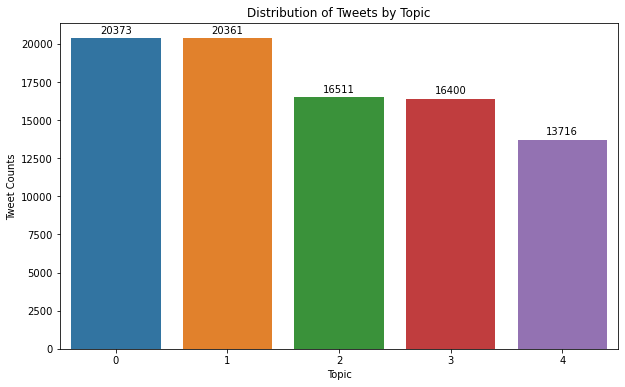

In [107]:
# Successful plotting of Number of tweets within each topic 

tweet_dist = df_sent['Dominant_Topic'].value_counts()
tweet_dist = tweet_dist.reset_index()

fix, ax = plt.subplots(figsize = (10, 6))
ax = sns.barplot(x = tweet_dist.index, y = tweet_dist['Dominant_Topic'])
ax.bar_label(ax.containers[0], padding = 3)
ax.set_xlabel('Topic')
ax.set_ylabel('Tweet Counts')
ax.set_title('Distribution of Tweets by Topic')


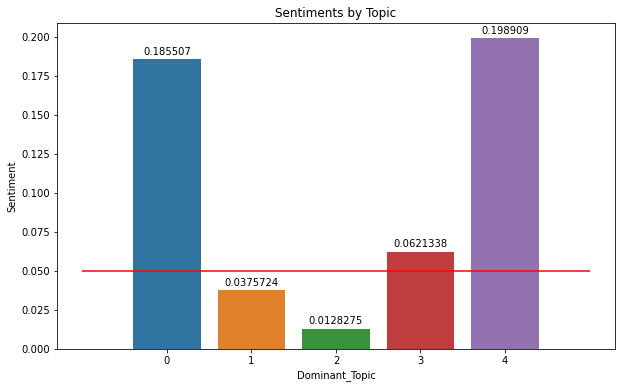

In [52]:
# Test Cell

# Successful reomval and graphing of sentiments by topic without 0 Values

df_sent_no_0 = df_sent[df_sent.Sentiment != 0.0]

# Graphing without 0 Valiiiiues

grp_sent_no_0 = df_sent_no_0.Sentiment.groupby(by = df_sent_no_0['Dominant_Topic']).mean()

fix, ax = plt.subplots(figsize = (10, 6))
ax = sns.barplot(x = grp_sent_no_0.index, y = grp_sent_no_0)
ax.bar_label(ax.containers[0], padding = 3)
ax.set_title('Sentiments by Topic')
ax.hlines(y = 0.05, xmin = -1, xmax = 5, colors = 'red'); # Remeber to change the xmax of hline to the number of topics chosen
# ax.bar(grp_sent.index, height = grp_sent)

In [ ]:
grp_sent = df_sent.Sentiment.groupby(by = df_sent['Dominant_Topic']).mean()

fix, ax = plt.subplots(figsize = (16, 10))
ax = sns.barplot(x = grp_sent.index, y = grp_sent)
ax.bar_label(ax.containers[0], padding = 3)
ax.set_title('Sentiments by Topic')
ax.hlines(y = 0.05, xmin = -1, xmax = 9, colors = 'red')
# ax.bar(grp_sent.index, height = grp_sent)

In [ ]:
# Delete this cell 
df_sent['Dominant_Topic'].value_counts(normalize = True)

In [ ]:
# Topic Distributions VISUALIZATION
topic_dist = pd.Series(df_topic_sents_keywords.Dominant_Topic, dtype = 'category')
# sns.countplot(topic_dist)
fix, ax = plt.subplots(figsize = (16, 10))
plt.hist(topic_dist, bins = 6)

In [ ]:
topic_dist

#### ============================================================================

# Below is the grid search the chunky one

In [ ]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=1500,
                                           passes=8,
                                           alpha=a,
                                           eta=b, 
                                           workers = 7)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=lem_noNone, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [ ]:
grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 3
max_topics = 9
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')
# Validation sets
num_of_docs = len(corpus)
corpus_sets = [#gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.5)), 
               gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]

corpus_title = ['50% Corpus', '75% Corpus', '100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=540)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    results_df = pd.DataFrame(model_results)
    pbar.close()

In [ ]:
results_df = pd.read_csv('Data/first-gs-results-24h')
results_df.drop(columns = 'Unnamed: 0', inplace = True)

In [ ]:
results_df[(results_df['Coherence'] >= 0.38) & (results_df['Topics'] == 5 )]

# =============================================================================

In [ ]:
results_df.Validation_Set.value_counts()

In [ ]:
# sns.lineplot(x= range(len(results_df['Coherence'])), y = results_df['Coherence'])

fig, ax = plt.subplots(figsize = (15, 10))
ax.plot(np.linspace(1, 540, 540),'Coherence', data = results_df )
ax.set_title('GridSearch CV');

In [ ]:
import matplotlib.pyplot as plt

In [ ]:

ax1_df = results_df.Coherence.groupby(by=results_df['Validation_Set']).mean()
ax2_df = results_df.Coherence.groupby(by=results_df['Alpha']).mean()
ax3_df = results_df.Coherence.groupby(by=results_df['Beta']).mean()
ax4_df = results_df.Coherence.groupby(by=results_df['Topics']).mean()


fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1 , figsize = (15, 15))




ax1.plot(ax1_df)
ax1.set_title('Corpus Size')

ax2.plot(ax2_df)
ax2.set_title('Alpha')

ax3.plot(ax3_df)
ax3.set_title('Beta')

ax4.plot(ax4_df)
ax4.set_title('Topics')